In [1]:
# !pip install torch==1.11.0+cpu torchvision==0.12.0+cpu torchaudio==0.11.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip install functorch

# print("--> Restarting colab instance") 
# get_ipython().kernel.do_shutdown(True)

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchmetrics import Accuracy

import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    )
])

batch_size = 64
device = "cuda"

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

Files already downloaded and verified
Files already downloaded and verified


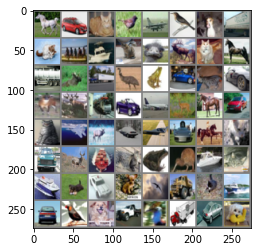

horse car   cat   bird  plane bird  dog   truck cat   ship  ship  cat   bird  deer  cat   horse truck deer  truck bird  frog  car   cat   car   deer  deer  truck car   plane deer  horse car   cat   plane deer  car   plane car   horse cat   car   deer  ship  cat   frog  bird  ship  cat   ship  dog   car   dog   bird  truck cat   ship  car   bird  dog   truck bird  truck car   dog  


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Stateful PyTorch

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
def to_device(tensors, device="cpu"):
    "Put tensors on device"
    if isinstance(tensors, (list, tuple)):
        return tuple(to_device(t, device) for t in tensors)
    elif isinstance(tensors, torch.Tensor):
        return tensors.to(device)
    else:
        raise Exception("Not a torch tensor-ish")

In [8]:
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
metric = Accuracy().to(device)

In [9]:
for epoch in tqdm(range(5)):  # loop over the dataset multiple times
    metric.reset()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = to_device(data, device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        acc = metric(outputs, labels)

        # print statistics
        running_loss += loss.item()
    print(f'[{epoch}] loss: {running_loss / 2000:.3f}, accuracy: {metric.compute():.3f}')

print('Finished Training')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[0] loss: 0.698, accuracy: 0.339


  0%|          | 0/782 [00:00<?, ?it/s]

[1] loss: 0.601, accuracy: 0.440


  0%|          | 0/782 [00:00<?, ?it/s]

[2] loss: 0.557, accuracy: 0.483


  0%|          | 0/782 [00:00<?, ?it/s]

[3] loss: 0.531, accuracy: 0.511


  0%|          | 0/782 [00:00<?, ?it/s]

[4] loss: 0.513, accuracy: 0.527
Finished Training


In [10]:
batch = next(iter(test_dataloader))
images, labels = to_device(batch, device)
preds = model(images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")

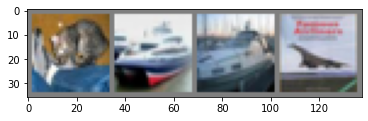

dog/cat   ship/ship  car/ship  ship/plane


In [11]:
# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{classes[preds[j]]}/{classes[labels[j]]:5s}' for j in range(4)))

# Functional PyTorch

In [22]:
from functorch import make_functional, grad_and_value

In [28]:
model = Classifier().to(device=device)
functional_model, params = make_functional(model)
metric = Accuracy().to(device)

In [29]:
def sgd_optimizer(weights, gradients, learning_rate):
    "naive SGD implementation"
    return [weight - learning_rate * gradient for weight, gradient in zip(weights, gradients)]

In [30]:
def compute_stateless_loss(params, inputs, labels):
    outputs = functional_model(params, inputs)
    loss = F.cross_entropy(outputs, labels)
    return loss

compute_gradients = grad_and_value(compute_stateless_loss)

In [34]:
def functional_step(params, inputs, labels):
    gradients, loss = compute_gradients(params, inputs, labels)
    params = sgd_optimizer(params, gradients, 1e-2)
    return params, loss

In [35]:
def train(functional_step, params, metric):
    running_loss = 0.
    metric.reset()
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        inputs, labels = to_device(data, device)
        params, loss = functional_step(params, inputs, labels)
        running_loss += loss.item()
        
        # new forward
        outputs = functional_model(params, inputs)
        metric(outputs, labels)
        
    return params, running_loss, metric

In [36]:
for epoch in tqdm(range(5)):
    params, running_loss, metric = train(functional_step, params, metric)
    print(f'[{epoch}] loss: {running_loss / 2000:.3f}, accuracy: {metric.compute():.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
batch = next(iter(test_dataloader))
images, labels = to_device(batch, device)
preds = functional_model(params, images).argmax(axis=1)
images, preds, labels = to_device([images, preds, labels], device="cpu")

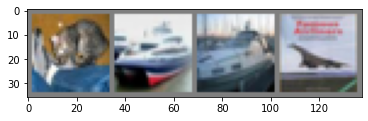

frog/cat   ship/ship  car/ship  plane/plane


In [38]:
# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print(' '.join(f'{classes[preds[j]]}/{classes[labels[j]]:5s}' for j in range(4)))